In [1]:
import pandas as pd
import numpy as np
import os
import netCDF4 as nc  
import matplotlib.pyplot as plt
from ripser import Rips
rips = Rips(maxdim=1)
import pickle
from tqdm import tqdm
from datetime import date,timedelta
import tcripser as tcr
import cartopy.crs as ccrs
import persim
import cartopy.feature as cfeature

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [2]:
# Get the path of the notebook file
notebook_path = os.path.abspath('__file__')

# Directory containing the notebook file
notebook_directory = os.path.dirname(notebook_path)

# Loading the data

In [3]:
dSet_SL = nc.Dataset(notebook_directory+"/Data/slp.daily.nc")
# Extract variables from the dataset
# This example assumes there are time, lat, lon, and a variable 'hgt'
time = dSet_SL.variables['time'][:]
lat = dSet_SL.variables['lat'][:]
lon = dSet_SL.variables['lon'][:]
slp = dSet_SL.variables['slp'][:]

In [4]:
lat_cut = [[22.5,70]]
lon_cut = [[280,360],[0,50]]

In [5]:
# Function to check if a value is within any of the specified ranges
def is_in_ranges(value, ranges):
    for r in ranges:
        if r[0] <= value <= r[1]:
            return True
    return False

In [6]:
def give_index(list,list_cut):
    indices = []
    for i in range(len(list.data)):
        if is_in_ranges(list.data[i],list_cut):
            indices.append(i)
    return indices

lon_index = give_index(lon,lon_cut)
lat_index = give_index(lat,lat_cut)

In [7]:
slp_new = slp[:,lat_index,:][:,:,lon_index]

In [8]:
slp.data.shape

(27919, 73, 144)

## Flattening the HGT

In [9]:
slp_list = []
for i in range(len(slp_new)):
    slp_list.append(np.array(np.hstack((slp_new[i][:, 21:], slp_new[i][:, 0:21])).data.flatten()))

# Normalizing the data

In [10]:
start_year = 1948 

In [11]:
def del_29_Feb(reading_list,start_year):
    step = 0
    while start_year + step < 2024:
        if (start_year+step)%4 == 0:
            del reading_list[step*365+59]
        step += 1
    return reading_list[:step*365]

In [12]:
slp_list = del_29_Feb(slp_list,1948)

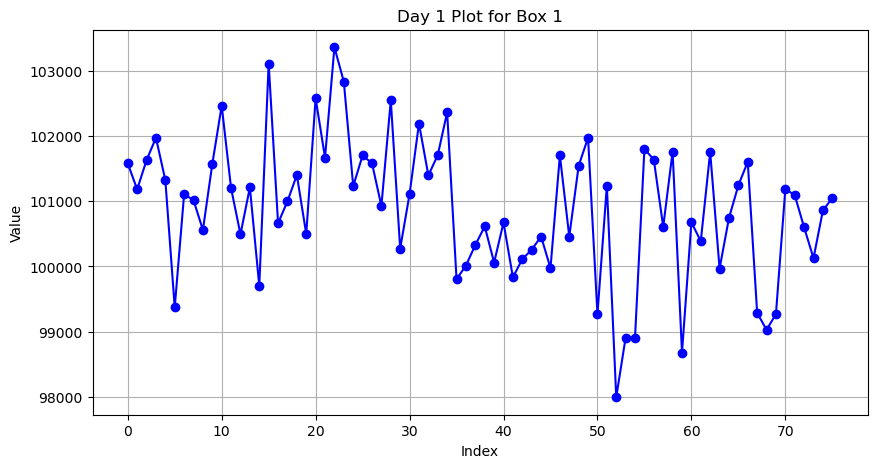

In [13]:
day_1 = []
for i in range(76):
    day_1.append(slp_list[i*365][0])
    
# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(day_1, marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('Day 1 Plot for Box 1')
plt.xlabel('Index')
plt.ylabel('Value')

# Show grid
plt.grid(True)

# Display the plot
plt.show()

In [14]:
def av_day(reading_list):
    num_year = int(len(reading_list)/365)
    av_list = reading_list[:365]

    for i in range(1,num_year):
        for j in range(365):
            av_list[j] = av_list[j] + reading_list[i*365+j]
    
    for i in range(len(av_list)):
        av_list[i] = av_list[i]*1/num_year
    
    for i in range(num_year):
        for j in range(365):
            reading_list[i*365+j] = reading_list[i*365+j] - av_list[j]

    return reading_list

In [15]:
slp_list = av_day(slp_list)

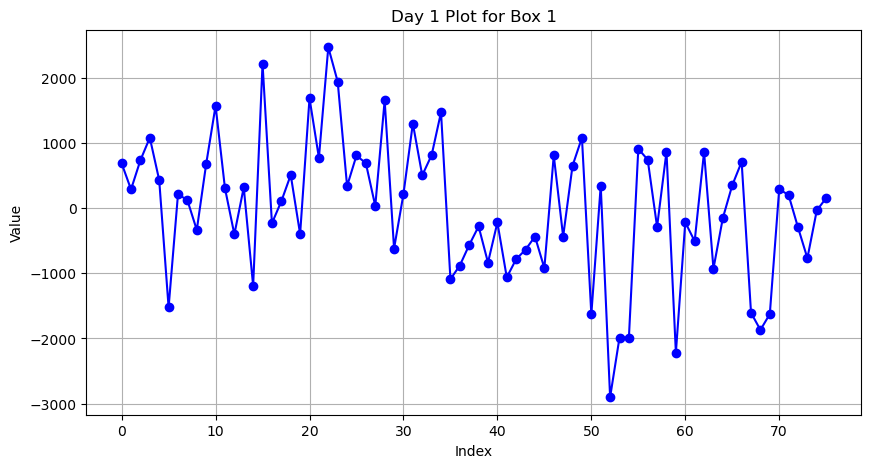

In [16]:
day_1 = []
for i in range(76):
    day_1.append(slp_list[i*365][0])
    
# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(day_1, marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('Day 1 Plot for Box 1')
plt.xlabel('Index')
plt.ylabel('Value')

# Show grid
plt.grid(True)

# Display the plot
plt.show()

In [17]:
len(lon_index[:21]),len(lon_index[21:])

(21, 32)

# Persistences for year (2023-1948)

# Generating persistence

In [18]:
persistences_positive = {}
persistences_positive_pair = {}
persistences_negative = {}
persistences_negative_pair = {}

for j in tqdm(range(2024-1948)):
    slp_cut = slp_list[j*365:(j+1)*365]
    persistences_positive_year = []
    persistences_negative_year = []
    persistences_positive_pair_year = []
    persistences_negative_pair_year = []

    for i in range(365):
        X = slp_cut[i].reshape((len(lat_index), len(lon_index)))

        P = tcr.computePH(-X)
        persistences_positive_year.append(P[P[:,0]==1][:,1:3][:,1]-P[P[:,0]==1][:,1:3][:,0])
        persistences_positive_pair_year.append(P[P[:,0]==1][:,1:3][:,:])

        P = tcr.computePH(X)
        persistences_negative_year.append(P[P[:,0]==1][:,1:3][:,1]-P[P[:,0]==1][:,1:3][:,0])
        persistences_negative_pair_year.append(P[P[:,0]==1][:,1:3][:,:])

    persistences_positive[j+1948] = persistences_positive_year
    persistences_positive_pair[j+1948] = persistences_positive_pair_year
    persistences_negative[j+1948] = persistences_negative_year
    persistences_negative_pair[j+1948] = persistences_negative_pair_year

100%|██████████| 76/76 [00:14<00:00,  5.35it/s]


In [19]:
for years in [1948,1949]:
    del persistences_positive_pair[years]
    del persistences_negative_pair[years]

In [20]:
slp_cut = slp_list[2*365:]
len(slp_cut)/365,len(persistences_positive_pair)

(74.0, 74)

In [21]:
import datetime

# Assuming your SLP list is called 'slp_values'
start_date = datetime.date(1950, 1, 1)  # Use date instead of datetime
# Create date range with extra periods to account for skipped leap days
date_range = pd.date_range(start=start_date, periods=len(slp_cut) + 50, freq='D')
# Filter out February 29th (leap days)
date_range_no_leap = date_range[~((date_range.month == 2) & (date_range.day == 29))]
# Take only the number of dates matching your SLP data and convert to date only
final_dates = date_range_no_leap[:len(slp_cut)].date  # .date removes time component
# Create the DataFrame
slp_df = pd.DataFrame({
    'date': final_dates,
    'slp': slp_cut
})

# Tracking

## Functions

In [22]:
def analyze_persistence_trajectories(persistences_data, year=None, start_year=None, end_year=None, 
                                   start_day=0, end_day=365, persistence_threshold=0.01):
    """
    Analyze and store persistence point trajectories for later analysis
    
    Returns:
    dict with keys:
    - 'trajectories': list of trajectories, each trajectory is a list of (time_index, date, birth, death, persistence)
    - 'trajectory_lengths': list of trajectory lengths (in days)  
    - 'trajectory_lifespans': list of trajectory lifespans (in actual time units)
    - 'dates': list of dates corresponding to each diagram (excludes Feb 29)
    - 'persistence_stats': statistics about persistence values over time
    - 'parameters': the parameters used for this analysis
    """
    
    def filter_by_persistence(diagram, threshold):
        """Filter diagram to keep only points with persistence >= threshold"""
        if len(diagram) == 0:
            return diagram
        persistence = diagram[:, 1] - diagram[:, 0]  # death - birth
        return diagram[persistence >= threshold]
    
    def generate_dates_no_leap(year, start_day=0, end_day=365):
        """Generate dates for a year, skipping February 29th"""
        dates = []
        current_date = date(year, 1, 1) + timedelta(days=start_day)
        end_date = date(year, 1, 1) + timedelta(days=min(end_day, 365))
        
        while current_date < end_date:
            # Skip February 29th
            if not (current_date.month == 2 and current_date.day == 29):
                dates.append(current_date)
            current_date += timedelta(days=1)
        
        return dates
    
    def generate_dates_multi_year(start_year, end_year):
        """Generate dates across multiple years, skipping February 29th"""
        dates = []
        for year in range(start_year, end_year + 1):
            year_dates = generate_dates_no_leap(year, 0, 365)
            dates.extend(year_dates)
        return dates
    
    # Extract the sequence of diagrams and corresponding dates
    if year is not None:
        # Single year analysis
        dates = generate_dates_no_leap(year, start_day, end_day)
        raw_diags = persistences_data[year][start_day:start_day + len(dates)]
        diags = [filter_by_persistence(d, persistence_threshold) for d in raw_diags]
        time_period = f"Year {year}, Days {start_day}-{start_day + len(dates) - 1}"
        
    elif start_year is not None and end_year is not None:
        # Multi-year analysis
        available_years = sorted(persistences_data.keys())
        years_to_use = [y for y in available_years if start_year <= y <= end_year]
        
        if not years_to_use:
            print(f"No data found for years {start_year}-{end_year}")
            return None
        
        dates = []
        raw_diags = []
        
        for y in years_to_use:
            year_dates = generate_dates_no_leap(y)
            # Only take as many diagrams as we have dates (excluding Feb 29)
            year_diags = persistences_data[y][:len(year_dates)]
            dates.extend(year_dates)
            raw_diags.extend(year_diags)
        
        diags = [filter_by_persistence(d, persistence_threshold) for d in raw_diags]
        time_period = f"Years {start_year}-{end_year}"
        
    else:
        # All years analysis
        dates = []
        raw_diags = []
        all_years = sorted(persistences_data.keys())
        
        for y in all_years:
            year_dates = generate_dates_no_leap(y)
            # Only take as many diagrams as we have dates (excluding Feb 29)
            year_diags = persistences_data[y][:len(year_dates)]
            dates.extend(year_dates)
            raw_diags.extend(year_diags)
        
        diags = [filter_by_persistence(d, persistence_threshold) for d in raw_diags]
        time_period = f"All Years {all_years[0]}-{all_years[-1]}"
    
    print(f"Analyzing trajectories for {time_period} with threshold {persistence_threshold}")
    print(f"Processing {len(diags)} time points (excluding Feb 29)...")
    
    # Track trajectories using Wasserstein matching
    trajectories = []  # List of trajectories
    active_trajectories = {}  # Currently active trajectories indexed by point
    next_traj_id = 0
    
    # Initialize with first diagram
    if len(diags) > 0 and len(diags[0]) > 0:
        for point_idx, point in enumerate(diags[0]):
            birth, death = point[0], point[1]
            persistence = death - birth
            trajectory = [(0, dates[0], birth, death, persistence)]
            active_trajectories[point_idx] = {
                'id': next_traj_id,
                'trajectory': trajectory,
                'last_point': point
            }
            next_traj_id += 1
    
    # Process remaining diagrams
    for i in range(1, len(diags)):
        if i % 1000 == 0:
            print(f"Processing time step {i}/{len(diags)-1}")
            
        D1 = diags[i-1]
        D2 = diags[i]
        
        if len(D1) == 0 or len(D2) == 0:
            # End all active trajectories if no points
            for traj_info in active_trajectories.values():
                trajectories.append(traj_info['trajectory'])
            active_trajectories = {}
            
            # Start new trajectories if D2 has points
            if len(D2) > 0:
                for point_idx, point in enumerate(D2):
                    birth, death = point[0], point[1]
                    persistence = death - birth
                    trajectory = [(i, dates[i], birth, death, persistence)]
                    active_trajectories[point_idx] = {
                        'id': next_traj_id,
                        'trajectory': trajectory,
                        'last_point': point
                    }
                    next_traj_id += 1
            continue
            
        # Compute Wasserstein matching
        d, M = persim.wasserstein(D1, D2, matching=True)
        
        new_active_trajectories = {}
        matched_indices_d2 = set()
        
        # Process matches
        for m in M:
            m0 = int(m[0])  # index in D1
            m1 = int(m[1])  # index in D2
            
            if -1 < m0 < len(D1) and -1 < m1 < len(D2):
                matched_indices_d2.add(m1)
                
                if m0 in active_trajectories:
                    # Continue existing trajectory
                    point = D2[m1]
                    birth, death = point[0], point[1]
                    persistence = death - birth
                    
                    traj_info = active_trajectories[m0]
                    traj_info['trajectory'].append((i, dates[i], birth, death, persistence))
                    traj_info['last_point'] = point
                    new_active_trajectories[m1] = traj_info
                else:
                    # Start new trajectory (shouldn't happen with proper matching, but just in case)
                    point = D2[m1]
                    birth, death = point[0], point[1]
                    persistence = death - birth
                    trajectory = [(i, dates[i], birth, death, persistence)]
                    new_active_trajectories[m1] = {
                        'id': next_traj_id,
                        'trajectory': trajectory,
                        'last_point': point
                    }
                    next_traj_id += 1
        
        # End unmatched trajectories from D1
        for old_idx, traj_info in active_trajectories.items():
            if old_idx >= len(D1) or not any(int(m[0]) == old_idx for m in M if -1 < int(m[0]) < len(D1) and -1 < int(m[1]) < len(D2)):
                trajectories.append(traj_info['trajectory'])
        
        # Start new trajectories for unmatched points in D2
        for point_idx, point in enumerate(D2):
            if point_idx not in matched_indices_d2:
                birth, death = point[0], point[1]
                persistence = death - birth
                trajectory = [(i, dates[i], birth, death, persistence)]
                new_active_trajectories[point_idx] = {
                    'id': next_traj_id,
                    'trajectory': trajectory,
                    'last_point': point
                }
                next_traj_id += 1
        
        active_trajectories = new_active_trajectories
    
    # End remaining active trajectories
    for traj_info in active_trajectories.values():
        trajectories.append(traj_info['trajectory'])
    
    # Calculate trajectory statistics
    trajectory_lengths = [len(traj) for traj in trajectories]
    trajectory_lifespans = []
    
    for traj in trajectories:
        if len(traj) > 1:
            start_date = traj[0][1]  # First date
            end_date = traj[-1][1]   # Last date
            lifespan = (end_date - start_date).days  # Difference in days
        else:
            lifespan = 0
        trajectory_lifespans.append(lifespan)
    
    # Calculate persistence statistics over time
    persistence_over_time = []
    for i, diag in enumerate(diags):
        if len(diag) > 0:
            persistences = diag[:, 1] - diag[:, 0]
            persistence_over_time.append({
                'time_index': i,
                'date': dates[i],
                'mean_persistence': np.mean(persistences),
                'max_persistence': np.max(persistences),
                'min_persistence': np.min(persistences),
                'num_features': len(persistences)
            })
    
    # Summary statistics
    results = {
        'trajectories': trajectories,
        'trajectory_lengths': trajectory_lengths,
        'trajectory_lifespans': trajectory_lifespans,
        'dates': dates,
        'persistence_over_time': persistence_over_time,
        'parameters': {
            'time_period': time_period,
            'persistence_threshold': persistence_threshold,
            'year': year,
            'start_year': start_year,
            'end_year': end_year,
            'start_day': start_day,
            'end_day': end_day,
            'total_time_points': len(diags),
            'total_trajectories': len(trajectories),
            'leap_days_excluded': True
        },
        'summary_stats': {
            'mean_trajectory_length': np.mean(trajectory_lengths) if trajectory_lengths else 0,
            'max_trajectory_length': max(trajectory_lengths) if trajectory_lengths else 0,
            'mean_trajectory_lifespan': np.mean(trajectory_lifespans) if trajectory_lifespans else 0,
            'max_trajectory_lifespan': max(trajectory_lifespans) if trajectory_lifespans else 0,
            'trajectories_longer_than_10_days': sum(1 for length in trajectory_lengths if length > 10),
            'trajectories_longer_than_30_days': sum(1 for length in trajectory_lengths if length > 30),
        }
    }
    
    print(f"Analysis complete:")
    print(f"  Total trajectories: {len(trajectories)}")
    print(f"  Mean trajectory length: {results['summary_stats']['mean_trajectory_length']:.2f} days")
    print(f"  Max trajectory length: {results['summary_stats']['max_trajectory_length']} days")
    print(f"  Trajectories > 10 days: {results['summary_stats']['trajectories_longer_than_10_days']}")
    print(f"  Trajectories > 30 days: {results['summary_stats']['trajectories_longer_than_30_days']}")
    print(f"  February 29th dates excluded: {results['parameters']['leap_days_excluded']}")
    
    return results

In [23]:
def get_trajectory_summary(results):
    """
    Get a summary DataFrame with one row per trajectory (sorted by length)
    
    Returns:
    --------
    pd.DataFrame with trajectory-level statistics
    """
    import pandas as pd
    import numpy as np
    
    trajectories = results['trajectories']
    trajectory_lengths = results['trajectory_lengths'] 
    trajectory_lifespans = results['trajectory_lifespans']
    
    if len(trajectories) == 0:
        return pd.DataFrame()
    
    # Get trajectory indices sorted by length (descending)
    sorted_indices = np.argsort(trajectory_lengths)[::-1]
    
    summary_data = []
    
    for rank, traj_idx in enumerate(sorted_indices, 1):
        trajectory = trajectories[traj_idx]
        traj_length = trajectory_lengths[traj_idx]
        traj_lifespan = trajectory_lifespans[traj_idx]
        
        # Extract trajectory statistics
        dates = [point[1] for point in trajectory]
        births = [point[2] for point in trajectory]
        deaths = [point[3] for point in trajectory]
        persistences = [point[4] for point in trajectory]
        
        summary_data.append({
            'trajectory_rank': rank,
            'trajectory_length': traj_length,
            'trajectory_lifespan': traj_lifespan,
            'start_date': dates[0],
            'end_date': dates[-1],
            'mean_persistence': np.mean(persistences),
            'max_persistence': np.max(persistences),
            'min_persistence': np.min(persistences),
            'std_persistence': np.std(persistences),
            'mean_birth': np.mean(births),
            'mean_death': np.mean(deaths),
            'dates_list': dates,
            'birth_death_pairs': [(b, d) for b, d in zip(births, deaths)],
            'persistence_values': persistences
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.set_index('trajectory_rank')
    
    print(f"Created summary DataFrame with {len(summary_df)} trajectories")
    
    return summary_df

In [24]:
def analyze_trajectory_statistics(df_summary, show_figure=False, save_path=None, font_size=12,color='grey'):
    """
    Analyze trajectory statistics from summary DataFrame to extract specific insights
    
    Parameters:
    -----------
    df_summary : pd.DataFrame
        Summary DataFrame from get_trajectory_summary function
    show_figure : bool
        Whether to display figures
    save_path : str
        Path to save figures (optional)
    font_size : int
        Universal font size for all plot elements
    
    Returns:
    --------
    dict with monthly and seasonal trajectory statistics
    """
    import pandas as pd
    import numpy as np
    import calendar
    import os
    
    if show_figure or save_path:
        import matplotlib.pyplot as plt
        plt.style.use('default')
        # Set universal font size
        plt.rcParams.update({'font.size': font_size})
    
    if save_path and not os.path.exists(save_path):
        os.makedirs(save_path)
    
    if len(df_summary) == 0:
        print("No trajectory data available")
        return {}
    
    print("=" * 60)
    print("TRAJECTORY ANALYSIS REPORT")
    print("=" * 60)
    
    # Extract trajectory data
    trajectory_data = []
    for idx, row in df_summary.iterrows():
        start_date = row['start_date']
        trajectory_data.append({
            'start_month': start_date.month,
            'start_year': start_date.year,
            'month_name': calendar.month_name[start_date.month],
            'trajectory_length': row['trajectory_length'],
            'mean_persistence': row['mean_persistence']
        })
    
    df_traj = pd.DataFrame(trajectory_data)
    
    # Add season information
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'
    
    df_traj['season'] = df_traj['start_month'].apply(get_season)
    
    # 1. AVERAGE TRAJECTORY LENGTH PER MONTH
    print("\n1. AVERAGE TRAJECTORY LENGTH PER MONTH")
    print("-" * 50)
    
    monthly_length = df_traj.groupby('start_month')['trajectory_length'].mean()
    monthly_results = []
    
    for month in range(1, 13):
        month_name = calendar.month_name[month]
        avg_length = monthly_length.get(month, 0)
        monthly_results.append({
            'month': month,
            'month_name': month_name,
            'avg_trajectory_length': avg_length
        })
        print(f"{month_name:>10}: {avg_length:.1f} days")
    
    # 2. AVERAGE TRAJECTORY LENGTH PER SEASON
    print("\n2. AVERAGE TRAJECTORY LENGTH PER SEASON")
    print("-" * 50)
    
    seasonal_length = df_traj.groupby('season')['trajectory_length'].mean()
    seasonal_results = []
    
    for season in ['Spring', 'Summer', 'Fall', 'Winter']:
        avg_length = seasonal_length.get(season, 0)
        seasonal_results.append({
            'season': season,
            'avg_trajectory_length': avg_length
        })
        print(f"{season:>8}: {avg_length:.1f} days")
    
    # 3. AVERAGE PERSISTENCE PER MONTH
    print("\n3. AVERAGE PERSISTENCE PER MONTH")
    print("-" * 50)
    
    monthly_persistence = df_traj.groupby('start_month')['mean_persistence'].mean()
    
    for month in range(1, 13):
        month_name = calendar.month_name[month]
        avg_persistence = monthly_persistence.get(month, 0)
        print(f"{month_name:>10}: {avg_persistence:.2f}")
        
        # Add to monthly results
        for result in monthly_results:
            if result['month'] == month:
                result['avg_persistence'] = avg_persistence
    
    # 4. AVERAGE PERSISTENCE PER SEASON
    print("\n4. AVERAGE PERSISTENCE PER SEASON")
    print("-" * 50)
    
    seasonal_persistence = df_traj.groupby('season')['mean_persistence'].mean()
    
    for season in ['Spring', 'Summer', 'Fall', 'Winter']:
        avg_persistence = seasonal_persistence.get(season, 0)
        print(f"{season:>8}: {avg_persistence:.2f}")
        
        # Add to seasonal results
        for result in seasonal_results:
            if result['season'] == season:
                result['avg_persistence'] = avg_persistence
    
    # 5. AVERAGE NUMBER OF TRAJECTORIES PER MONTH/YEAR
    print("\n5. AVERAGE NUMBER OF TRAJECTORIES PER MONTH/YEAR")
    print("-" * 50)
    
    # Count trajectories by month and year, then average across years
    monthly_counts = df_traj.groupby(['start_year', 'start_month']).size().reset_index(name='count')
    avg_monthly_trajectories = monthly_counts.groupby('start_month')['count'].mean()
    
    for month in range(1, 13):
        month_name = calendar.month_name[month]
        avg_count = avg_monthly_trajectories.get(month, 0)
        print(f"{month_name:>10}: {avg_count:.1f} trajectories/year")
        
        # Add to monthly results
        for result in monthly_results:
            if result['month'] == month:
                result['avg_trajectories_per_year'] = avg_count
    
    # Calculate seasonal frequency
    seasonal_frequency = {}
    for season in ['Spring', 'Summer', 'Fall', 'Winter']:
        season_months = []
        if season == 'Spring':
            season_months = [3, 4, 5]
        elif season == 'Summer':
            season_months = [6, 7, 8]
        elif season == 'Fall':
            season_months = [9, 10, 11]
        else:  # Winter
            season_months = [12, 1, 2]
        
        season_freq = sum([avg_monthly_trajectories.get(month, 0) for month in season_months])
        seasonal_frequency[season] = season_freq
        
        # Add to seasonal results
        for result in seasonal_results:
            if result['season'] == season:
                result['avg_trajectories_per_year'] = season_freq
    
    # Generate figures if requested
    if show_figure or save_path:
        # 1. Monthly trajectory length
        plt.figure(figsize=(10, 6))
        months = [result['month_name'][:3] for result in monthly_results]
        monthly_lengths = [result['avg_trajectory_length'] for result in monthly_results]
        
        plt.bar(months, monthly_lengths, color=color)
        plt.ylabel('Days')
        plt.xlabel('Month')
        plt.title('Monthly Average Trajectory Length')
        plt.xticks(rotation=90)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(f"{save_path}/monthly_trajectory_length.png", dpi=300, bbox_inches='tight')
        if show_figure:
            plt.show()
        else:
            plt.close()
        
        # 2. Seasonal trajectory length
        plt.figure(figsize=(8, 6))
        seasons = [result['season'] for result in seasonal_results]
        seasonal_lengths = [result['avg_trajectory_length'] for result in seasonal_results]
        
        plt.bar(seasons, seasonal_lengths,color=color)
        plt.ylabel('Days')
        plt.xlabel('Season')
        plt.title('Seasonal Average Trajectory Length')
        plt.xticks(rotation=90)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(f"{save_path}/seasonal_trajectory_length.png", dpi=300, bbox_inches='tight')
        if show_figure:
            plt.show()
        else:
            plt.close()
        
        # 3. Monthly persistence
        plt.figure(figsize=(10, 6))
        monthly_persistences = [result['avg_persistence'] for result in monthly_results]
        
        plt.bar(months, monthly_persistences, color=color)
        plt.ylabel('Persistence')
        plt.xlabel('Month')
        plt.title('Monthly Average Persistence')
        plt.xticks(rotation=90)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(f"{save_path}/monthly_persistence.png", dpi=300, bbox_inches='tight')
        if show_figure:
            plt.show()
        else:
            plt.close()
        
        # 4. Seasonal persistence
        plt.figure(figsize=(8, 6))
        seasonal_persistences = [result['avg_persistence'] for result in seasonal_results]
        
        plt.bar(seasons, seasonal_persistences, color=color)
        plt.ylabel('Persistence')
        plt.xlabel('Season')
        plt.title('Seasonal Average Persistence')
        plt.xticks(rotation=90)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(f"{save_path}/seasonal_persistence.png", dpi=300, bbox_inches='tight')
        if show_figure:
            plt.show()
        else:
            plt.close()
        
        # 5. Monthly trajectory frequency
        plt.figure(figsize=(10, 6))
        monthly_counts_plot = [result['avg_trajectories_per_year'] for result in monthly_results]
        
        plt.bar(months, monthly_counts_plot, color=color)
        plt.ylabel('Frequency')
        plt.xlabel('Month')
        plt.title('Monthly Average Trajectory Frequency')
        plt.xticks(rotation=90)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(f"{save_path}/monthly_frequency.png", dpi=300, bbox_inches='tight')
        if show_figure:
            plt.show()
        else:
            plt.close()
        
        # 6. Seasonal trajectory frequency
        plt.figure(figsize=(8, 6))
        seasonal_frequencies = [result['avg_trajectories_per_year'] for result in seasonal_results]
        
        plt.bar(seasons, seasonal_frequencies, color=color)
        plt.ylabel('Frequency')
        plt.xlabel('Season')
        plt.title('Seasonal Average Trajectory Frequency')
        plt.xticks(rotation=90)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(f"{save_path}/seasonal_frequency.png", dpi=300, bbox_inches='tight')
        if show_figure:
            plt.show()
        else:
            plt.close()
    
    # Compile results
    analysis_results = {
        'monthly_stats': monthly_results,
        'seasonal_stats': seasonal_results
    }
    
    return analysis_results

# Usage:
# results = analyze_trajectory_statistics(df_summary, show_figure=False, save_path="/path/to/save/plots", font_size=14)

## Analysis Positive

### 2000

In [25]:
results = analyze_persistence_trajectories(persistences_positive_pair, persistence_threshold=2000)

Analyzing trajectories for All Years 1950-2023 with threshold 2000
Processing 26992 time points (excluding Feb 29)...
Processing time step 1000/26991
Processing time step 2000/26991
Processing time step 3000/26991
Processing time step 4000/26991
Processing time step 5000/26991
Processing time step 6000/26991
Processing time step 7000/26991
Processing time step 8000/26991
Processing time step 9000/26991
Processing time step 10000/26991
Processing time step 11000/26991
Processing time step 12000/26991
Processing time step 13000/26991
Processing time step 14000/26991
Processing time step 15000/26991
Processing time step 16000/26991
Processing time step 17000/26991
Processing time step 18000/26991
Processing time step 19000/26991
Processing time step 20000/26991
Processing time step 21000/26991
Processing time step 22000/26991
Processing time step 23000/26991
Processing time step 24000/26991
Processing time step 25000/26991
Processing time step 26000/26991
Analysis complete:
  Total trajec

In [26]:
# Get trajectory summary (one row per trajectory)  
df_summary = get_trajectory_summary(results)
df_summary = df_summary[df_summary.trajectory_lifespan > 1]
len(df_summary)

Created summary DataFrame with 2995 trajectories


787

TRAJECTORY ANALYSIS REPORT

1. AVERAGE TRAJECTORY LENGTH PER MONTH
--------------------------------------------------
   January: 4.8 days
  February: 4.6 days
     March: 4.4 days
     April: 4.1 days
       May: 3.6 days
      June: 3.4 days
      July: 3.4 days
    August: 3.3 days
 September: 3.8 days
   October: 4.4 days
  November: 4.5 days
  December: 5.2 days

2. AVERAGE TRAJECTORY LENGTH PER SEASON
--------------------------------------------------
  Spring: 4.1 days
  Summer: 3.3 days
    Fall: 4.3 days
  Winter: 4.9 days

3. AVERAGE PERSISTENCE PER MONTH
--------------------------------------------------
   January: 2776.89
  February: 2779.09
     March: 2719.12
     April: 2666.77
       May: 2466.61
      June: 2479.97
      July: 2399.49
    August: 2521.82
 September: 2609.74
   October: 2688.26
  November: 2783.53
  December: 2775.01

4. AVERAGE PERSISTENCE PER SEASON
--------------------------------------------------
  Spring: 2650.74
  Summer: 2488.13
    Fall: 2713.

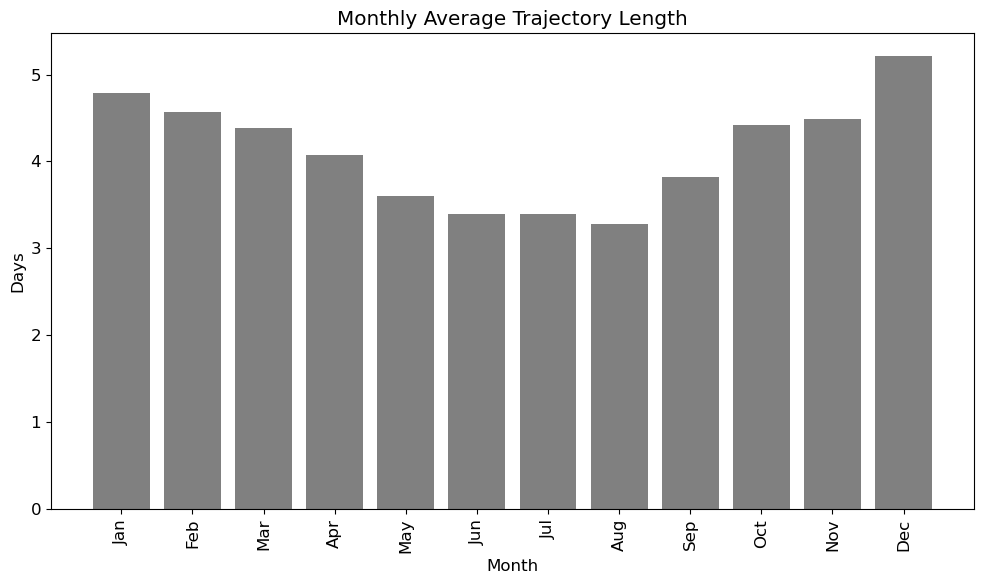

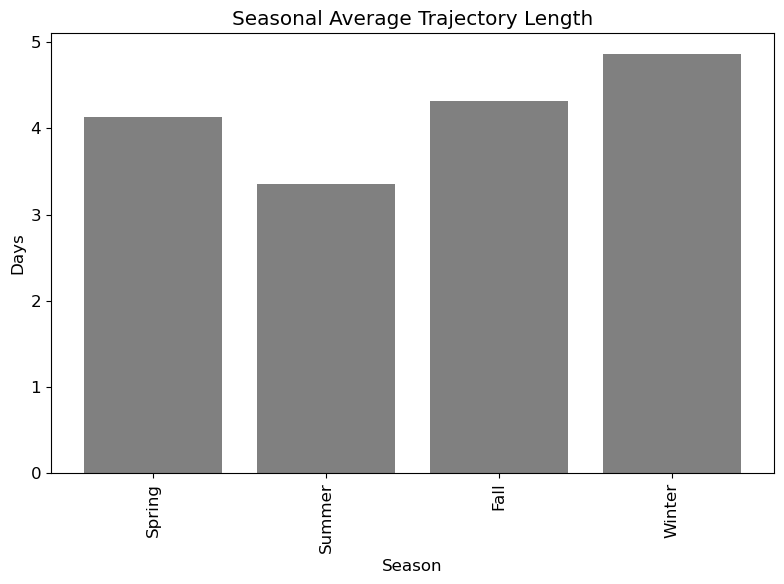

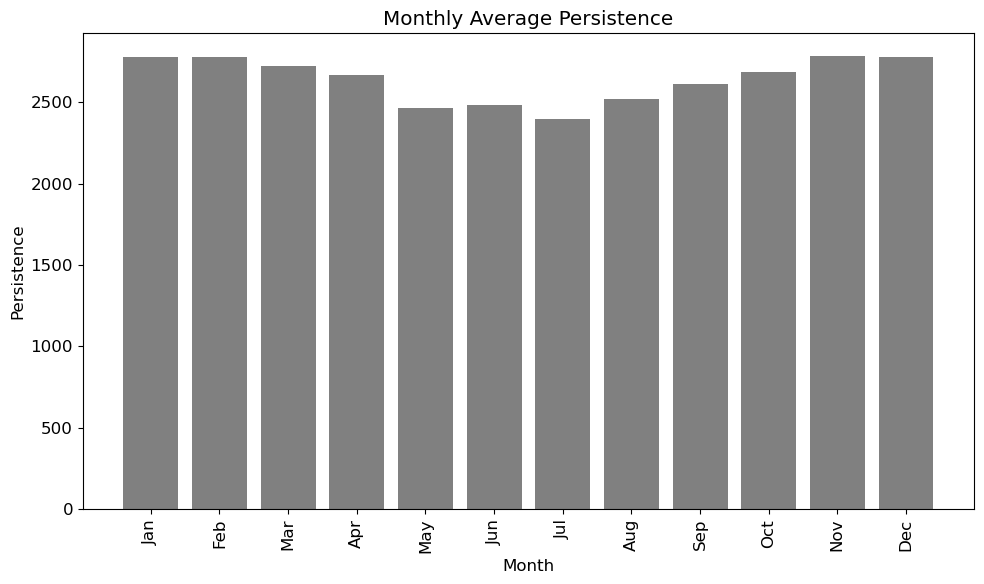

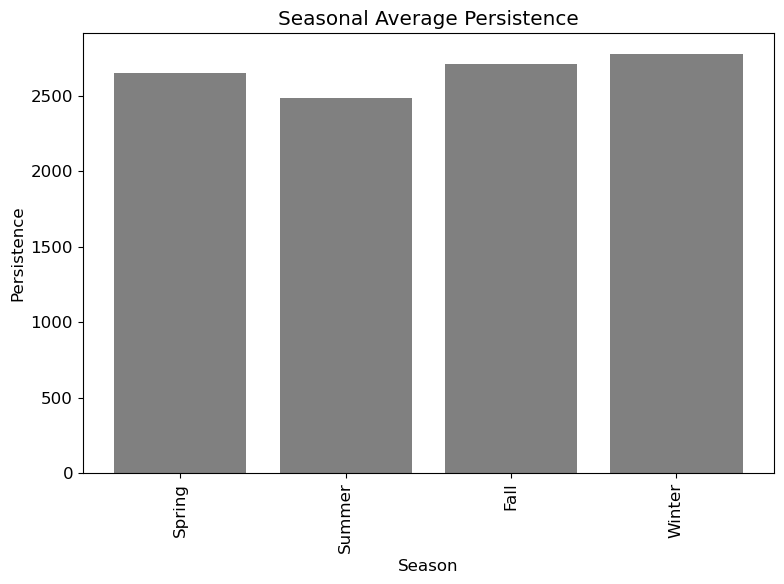

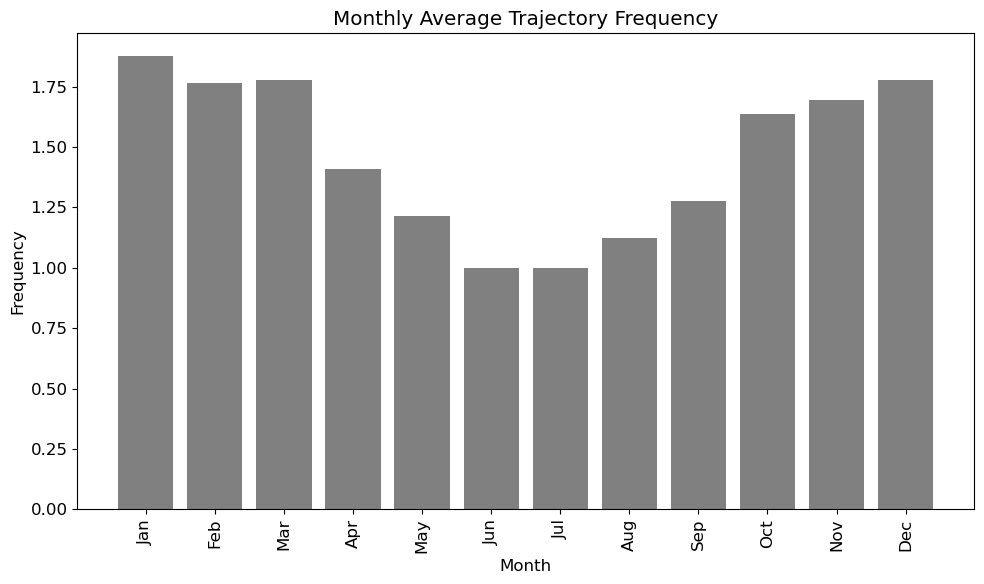

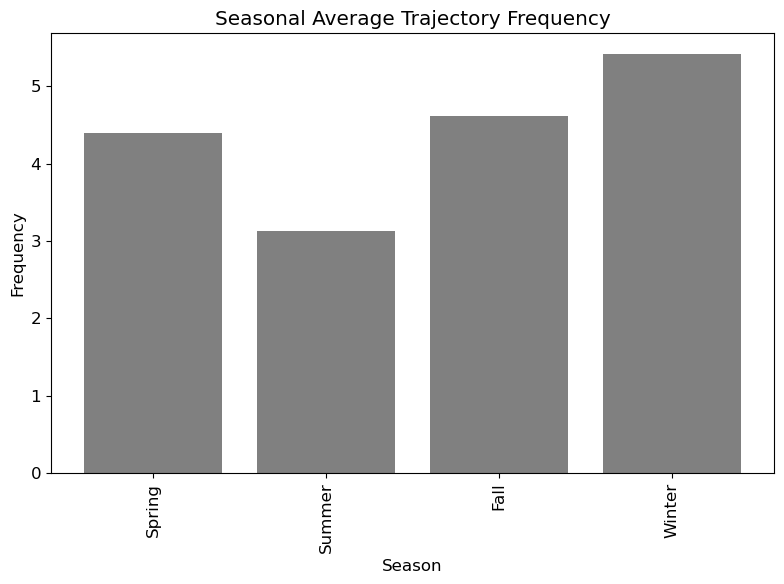

In [27]:
# Usage:
analysis_results = analyze_trajectory_statistics(df_summary,show_figure=True)

### 1000

In [28]:
results = analyze_persistence_trajectories(persistences_positive_pair, persistence_threshold=1000)

Analyzing trajectories for All Years 1950-2023 with threshold 1000
Processing 26992 time points (excluding Feb 29)...
Processing time step 1000/26991
Processing time step 2000/26991
Processing time step 3000/26991
Processing time step 4000/26991
Processing time step 5000/26991
Processing time step 6000/26991
Processing time step 7000/26991
Processing time step 8000/26991
Processing time step 9000/26991
Processing time step 10000/26991
Processing time step 11000/26991
Processing time step 12000/26991
Processing time step 13000/26991
Processing time step 14000/26991
Processing time step 15000/26991
Processing time step 16000/26991
Processing time step 17000/26991
Processing time step 18000/26991
Processing time step 19000/26991
Processing time step 20000/26991
Processing time step 21000/26991
Processing time step 22000/26991
Processing time step 23000/26991
Processing time step 24000/26991
Processing time step 25000/26991
Processing time step 26000/26991
Analysis complete:
  Total trajec

In [29]:
# Get trajectory summary (one row per trajectory)  
df_summary = get_trajectory_summary(results)
df_summary = df_summary[df_summary.trajectory_lifespan > 1]
len(df_summary)

Created summary DataFrame with 6937 trajectories


2876

In [30]:
df_summary.head()

,trajectory_length,trajectory_lifespan,start_date,end_date,mean_persistence,max_persistence,min_persistence,std_persistence,mean_birth,mean_death,dates_list,birth_death_pairs,persistence_values
trajectory_rank,,,,,,,,,,,,,
1,59,58,1966-01-08,1966-03-07,2409.474841,5117.937500,1013.171875,974.055142,615.878708,3025.353549,"[1966-01-08, 1966-01-09, 1966-01-10, 1966-01-1...","[(400.578125, 1953.3515625), (346.890625, 2463...","[1552.7734375, 2117.0390625, 1160.5, 1178.875,..."
2,44,43,1955-01-15,1955-02-27,2054.454545,3848.101562,1051.226562,738.287166,805.442827,2859.897372,"[1955-01-15, 1955-01-16, 1955-01-17, 1955-01-1...","[(1599.5234375, 3144.8125), (1673.0546875, 294...","[1545.2890625, 1270.7578125, 2157.8671875, 125..."
3,43,42,1997-10-28,1997-12-09,2182.842842,4256.812500,1053.781250,793.601587,864.853198,3047.696039,"[1997-10-28, 1997-10-29, 1997-10-30, 1997-10-3...","[(448.921875, 2104.859375), (616.1015625, 2801...","[1655.9375, 2184.8984375, 1405.59375, 1333.406..."
4,40,39,2010-01-29,2010-03-09,2378.859180,5131.085938,1067.421875,883.327838,819.374023,3198.233203,"[2010-01-29, 2010-01-30, 2010-01-31, 2010-02-0...","[(308.6875, 1396.921875), (162.078125, 2538.35...","[1088.234375, 2376.28125, 1446.3515625, 1316.9..."
5,38,37,1957-02-10,1957-03-19,2227.441612,3614.796875,1152.796875,691.373620,525.196135,2752.637747,"[1957-02-10, 1957-02-11, 1957-02-12, 1957-02-1...","[(567.3359375, 3176.59375), (465.6484375, 2288...","[2609.2578125, 1823.1796875, 2165.21875, 3070...."


TRAJECTORY ANALYSIS REPORT

1. AVERAGE TRAJECTORY LENGTH PER MONTH
--------------------------------------------------
   January: 7.2 days
  February: 7.4 days
     March: 6.5 days
     April: 7.2 days
       May: 6.1 days
      June: 6.0 days
      July: 4.8 days
    August: 5.2 days
 September: 6.5 days
   October: 6.5 days
  November: 7.1 days
  December: 7.1 days

2. AVERAGE TRAJECTORY LENGTH PER SEASON
--------------------------------------------------
  Spring: 6.6 days
  Summer: 5.4 days
    Fall: 6.7 days
  Winter: 7.2 days

3. AVERAGE PERSISTENCE PER MONTH
--------------------------------------------------
   January: 1833.93
  February: 1889.62
     March: 1748.13
     April: 1673.47
       May: 1612.39
      June: 1554.43
      July: 1465.20
    August: 1543.65
 September: 1653.51
   October: 1789.04
  November: 1774.43
  December: 1879.62

4. AVERAGE PERSISTENCE PER SEASON
--------------------------------------------------
  Spring: 1683.39
  Summer: 1523.30
    Fall: 1743.

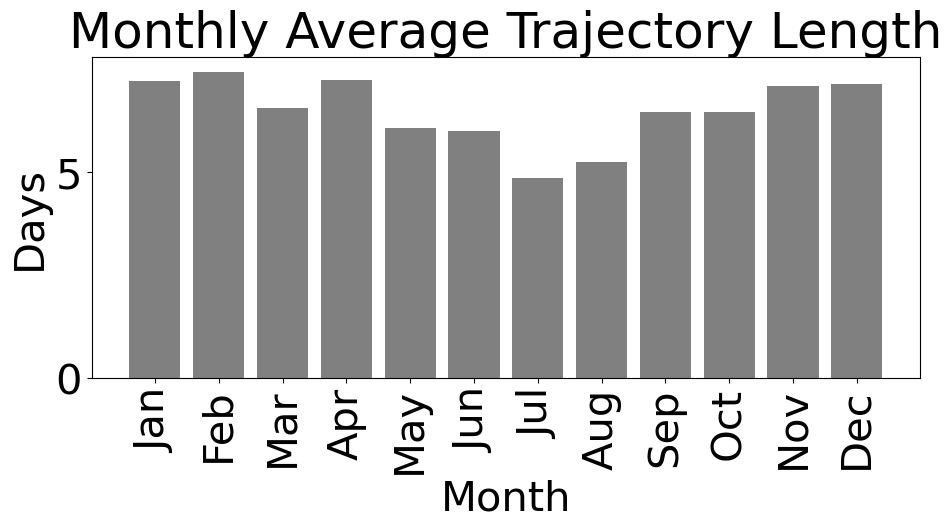

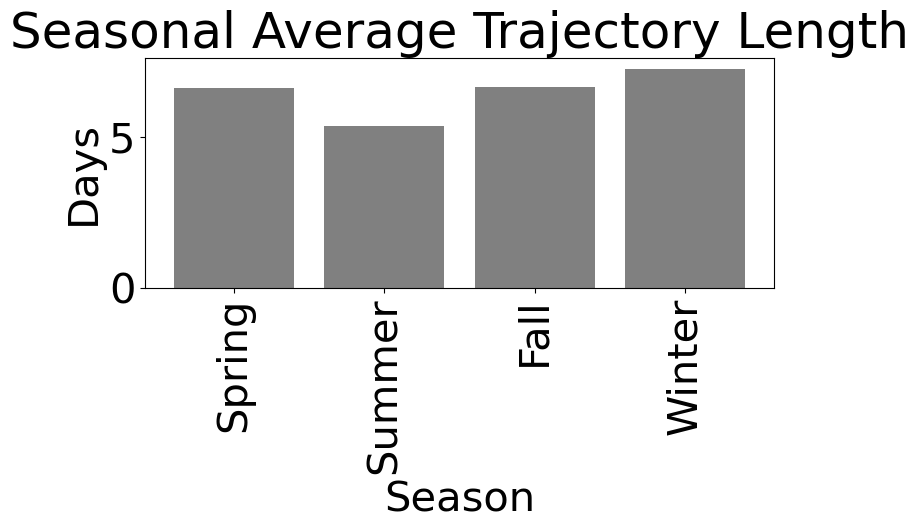

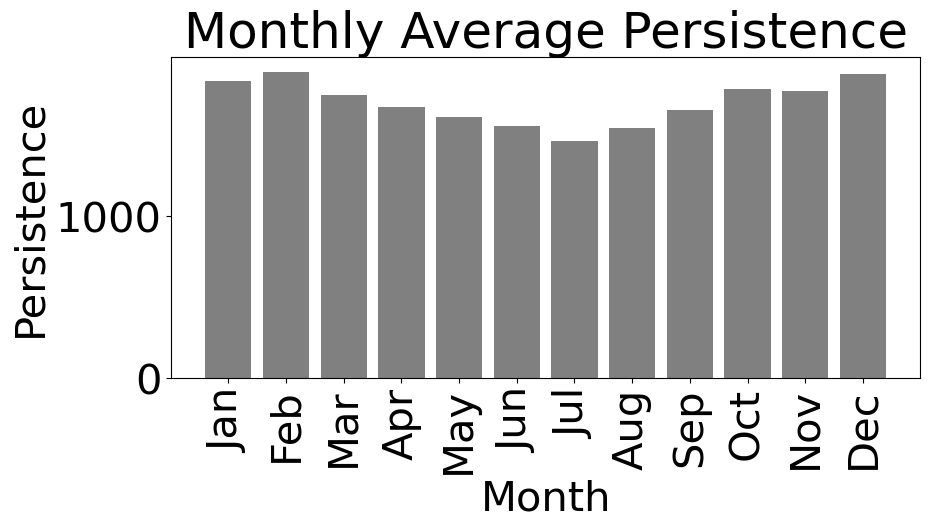

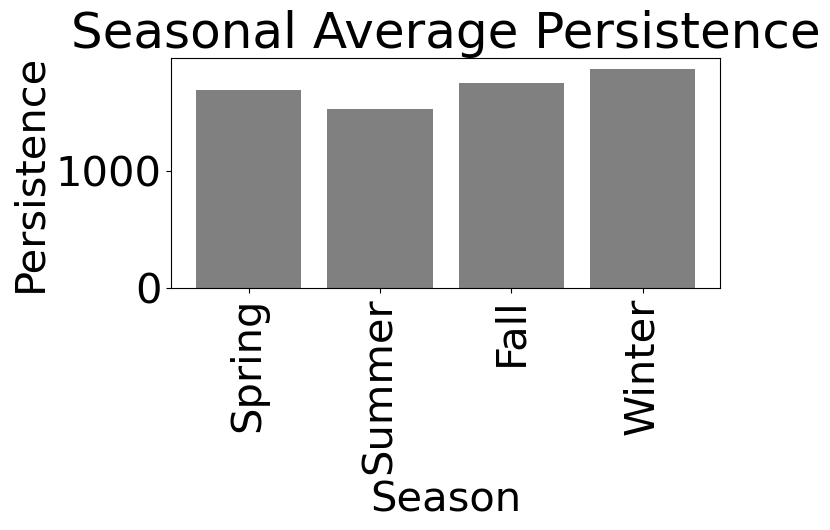

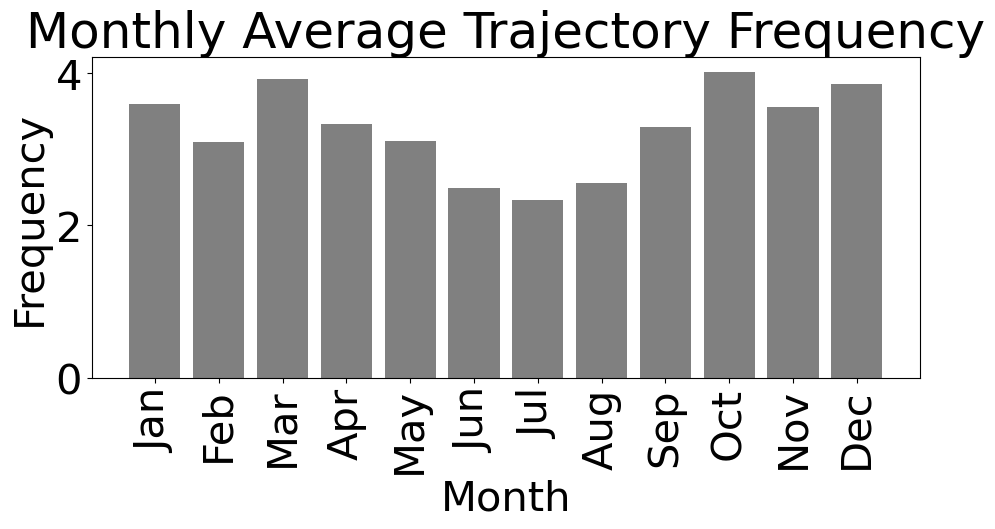

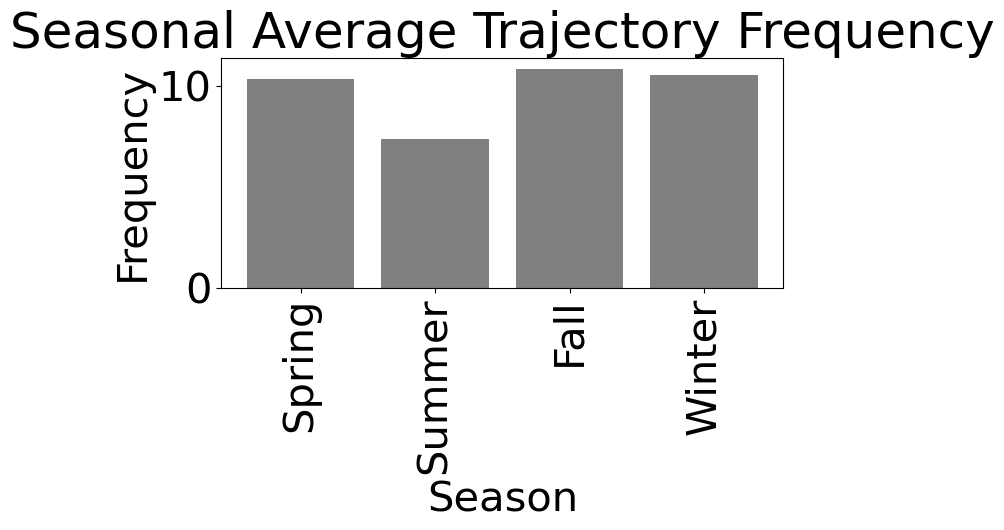

In [31]:
# Usage:
analysis_results = analyze_trajectory_statistics(df_summary,show_figure=True,save_path="figures/sup_level/",font_size=30)

## Analysis negative

### 1000

In [32]:
results = analyze_persistence_trajectories(persistences_negative_pair, persistence_threshold=1000)

Analyzing trajectories for All Years 1950-2023 with threshold 1000
Processing 26992 time points (excluding Feb 29)...
Processing time step 1000/26991
Processing time step 2000/26991
Processing time step 3000/26991
Processing time step 4000/26991
Processing time step 5000/26991
Processing time step 6000/26991
Processing time step 7000/26991
Processing time step 8000/26991
Processing time step 9000/26991
Processing time step 10000/26991
Processing time step 11000/26991
Processing time step 12000/26991
Processing time step 13000/26991
Processing time step 14000/26991
Processing time step 15000/26991
Processing time step 16000/26991
Processing time step 17000/26991
Processing time step 18000/26991
Processing time step 19000/26991
Processing time step 20000/26991
Processing time step 21000/26991
Processing time step 22000/26991
Processing time step 23000/26991
Processing time step 24000/26991
Processing time step 25000/26991
Processing time step 26000/26991
Analysis complete:
  Total trajec

In [33]:
# Get trajectory summary (one row per trajectory)  
df_summary = get_trajectory_summary(results)
df_summary = df_summary[df_summary.trajectory_lifespan > 1]
len(df_summary)

Created summary DataFrame with 2646 trajectories


863

In [34]:
df_summary.head()

,trajectory_length,trajectory_lifespan,start_date,end_date,mean_persistence,max_persistence,min_persistence,std_persistence,mean_birth,mean_death,dates_list,birth_death_pairs,persistence_values
trajectory_rank,,,,,,,,,,,,,
1,21,20,1992-01-13,1992-02-02,1680.750000,2677.437500,1003.312500,457.789182,1041.550967,2722.300967,"[1992-01-13, 1992-01-14, 1992-01-15, 1992-01-1...","[(1188.1640625, 2931.0234375), (443.59375, 312...","[1742.859375, 2677.4375, 1992.390625, 1032.375..."
2,20,19,1978-10-08,1978-10-27,1466.544922,2106.960938,1009.343750,319.751458,519.175781,1985.720703,"[1978-10-08, 1978-10-09, 1978-10-10, 1978-10-1...","[(1574.3203125, 2639.8125), (1153.6875, 2477.7...","[1065.4921875, 1324.046875, 1009.34375, 1118.9..."
3,19,18,2000-01-07,2000-01-25,1876.247533,2865.062500,1229.500000,512.396850,1331.042352,3207.289885,"[2000-01-07, 2000-01-08, 2000-01-09, 2000-01-1...","[(861.1875, 2279.8359375), (413.296875, 1762.3...","[1418.6484375, 1349.0546875, 1233.15625, 1375...."
4,19,18,1982-12-11,1982-12-29,1452.872122,2433.437500,1038.296875,394.099358,588.652138,2041.524260,"[1982-12-11, 1982-12-12, 1982-12-13, 1982-12-1...","[(586.40625, 1636.9296875), (794.2734375, 2003...","[1050.5234375, 1209.3203125, 1118.2890625, 153..."
5,16,15,2005-01-23,2005-02-07,2027.605469,3014.046875,1314.890625,496.273687,1435.135254,3462.740723,"[2005-01-23, 2005-01-24, 2005-01-25, 2005-01-2...","[(1954.7421875, 3523.890625), (2230.5078125, 3...","[1569.1484375, 1372.296875, 2166.1875, 2739.38..."


TRAJECTORY ANALYSIS REPORT

1. AVERAGE TRAJECTORY LENGTH PER MONTH
--------------------------------------------------
   January: 5.6 days
  February: 4.8 days
     March: 5.1 days
     April: 4.5 days
       May: 4.6 days
      June: 4.1 days
      July: 4.2 days
    August: 3.7 days
 September: 4.2 days
   October: 4.8 days
  November: 5.0 days
  December: 5.3 days

2. AVERAGE TRAJECTORY LENGTH PER SEASON
--------------------------------------------------
  Spring: 4.8 days
  Summer: 4.0 days
    Fall: 4.8 days
  Winter: 5.2 days

3. AVERAGE PERSISTENCE PER MONTH
--------------------------------------------------
   January: 1534.57
  February: 1516.72
     March: 1449.43
     April: 1359.71
       May: 1334.68
      June: 1317.16
      July: 1238.12
    August: 1280.37
 September: 1384.99
   October: 1436.52
  November: 1440.47
  December: 1512.86

4. AVERAGE PERSISTENCE PER SEASON
--------------------------------------------------
  Spring: 1394.27
  Summer: 1283.99
    Fall: 1426.

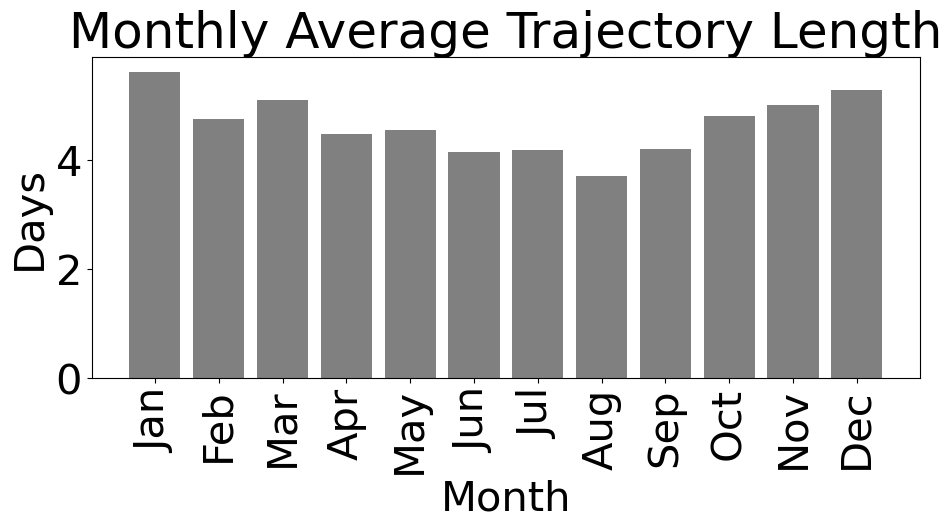

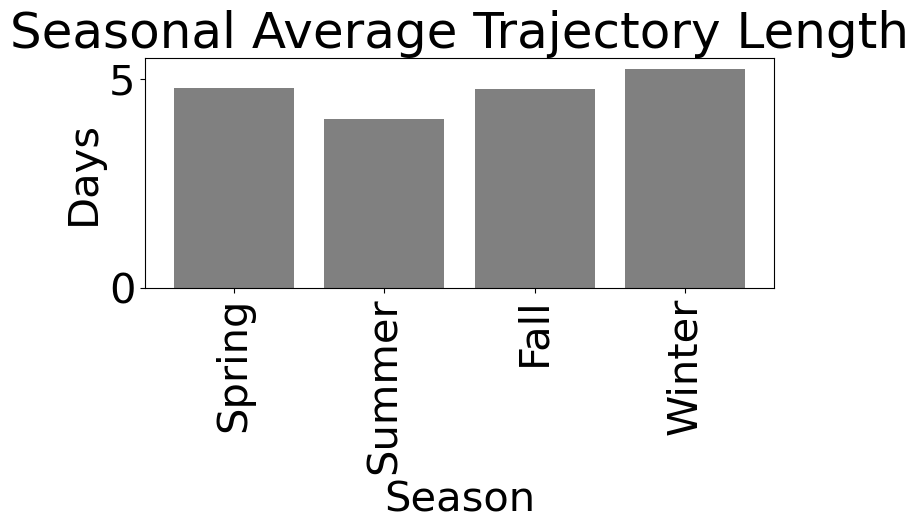

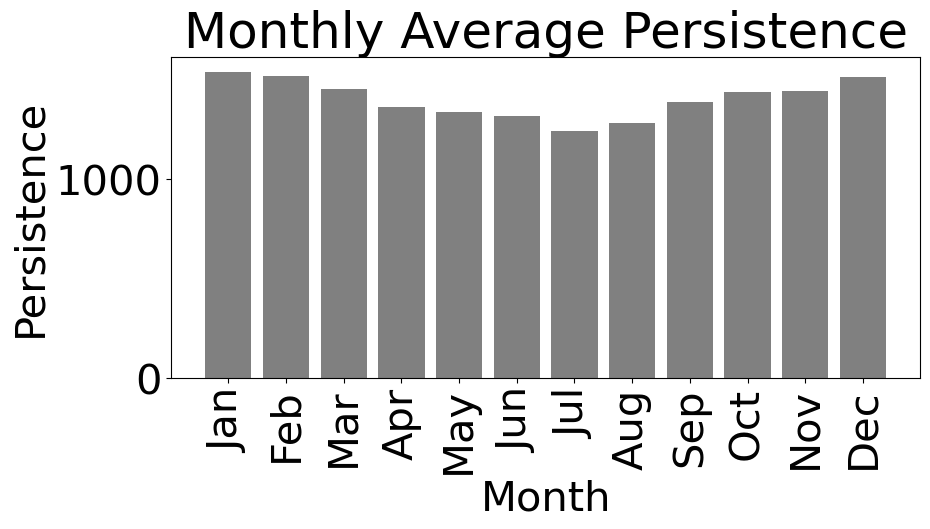

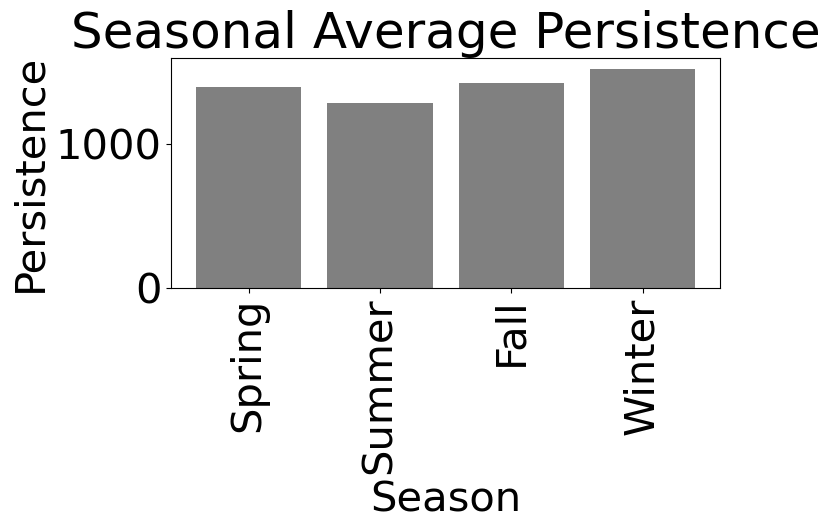

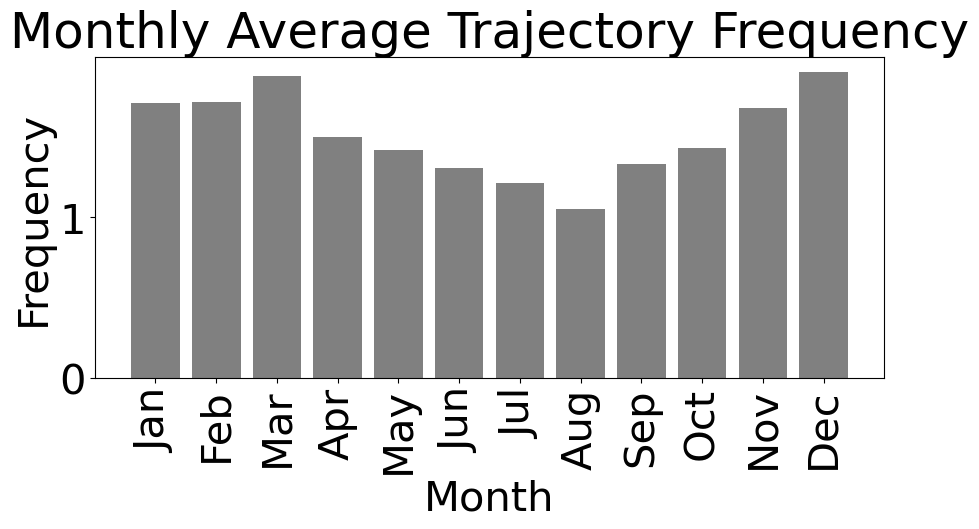

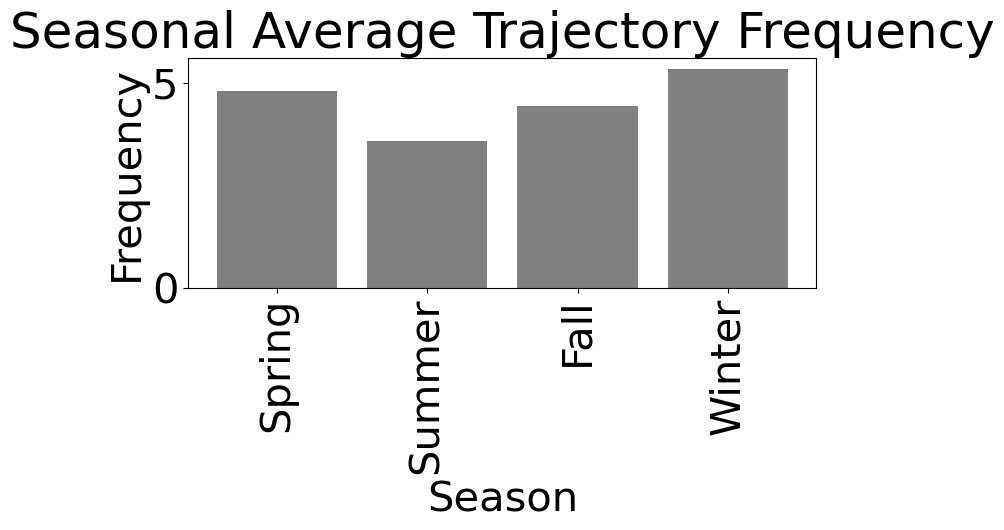

In [35]:
# Usage:
analysis_results = analyze_trajectory_statistics(df_summary,show_figure=True,save_path="figures/sub_level/",font_size=30)

### 2000

In [35]:
results = analyze_persistence_trajectories(persistences_negative_pair, persistence_threshold=2000)

Analyzing trajectories for All Years 1950-2023 with threshold 2000
Processing 26992 time points (excluding Feb 29)...
Processing time step 1000/26991
Processing time step 2000/26991
Processing time step 3000/26991
Processing time step 4000/26991
Processing time step 5000/26991
Processing time step 6000/26991
Processing time step 7000/26991
Processing time step 8000/26991
Processing time step 9000/26991
Processing time step 10000/26991
Processing time step 11000/26991
Processing time step 12000/26991
Processing time step 13000/26991
Processing time step 14000/26991
Processing time step 15000/26991
Processing time step 16000/26991
Processing time step 17000/26991
Processing time step 18000/26991
Processing time step 19000/26991
Processing time step 20000/26991
Processing time step 21000/26991
Processing time step 22000/26991
Processing time step 23000/26991
Processing time step 24000/26991
Processing time step 25000/26991
Processing time step 26000/26991
Analysis complete:
  Total trajec

In [36]:
# Get trajectory summary (one row per trajectory)  
df_summary = get_trajectory_summary(results)
df_summary = df_summary[df_summary.trajectory_lifespan > 1]
len(df_summary)

Created summary DataFrame with 299 trajectories


36

TRAJECTORY ANALYSIS REPORT

1. AVERAGE TRAJECTORY LENGTH PER MONTH
--------------------------------------------------
   January: 3.6 days
  February: 3.6 days
     March: 3.2 days
     April: 3.0 days
       May: 0.0 days
      June: 0.0 days
      July: 0.0 days
    August: 0.0 days
 September: 0.0 days
   October: 3.0 days
  November: 3.0 days
  December: 3.4 days

2. AVERAGE TRAJECTORY LENGTH PER SEASON
--------------------------------------------------
  Spring: 3.2 days
  Summer: 0.0 days
    Fall: 3.0 days
  Winter: 3.5 days

3. AVERAGE PERSISTENCE PER MONTH
--------------------------------------------------
   January: 2433.86
  February: 2462.52
     March: 2391.27
     April: 2215.74
       May: 0.00
      June: 0.00
      July: 0.00
    August: 0.00
 September: 0.00
   October: 2530.33
  November: 2613.53
  December: 2463.01

4. AVERAGE PERSISTENCE PER SEASON
--------------------------------------------------
  Spring: 2362.02
  Summer: 0.00
    Fall: 2571.93
  Winter: 2452.

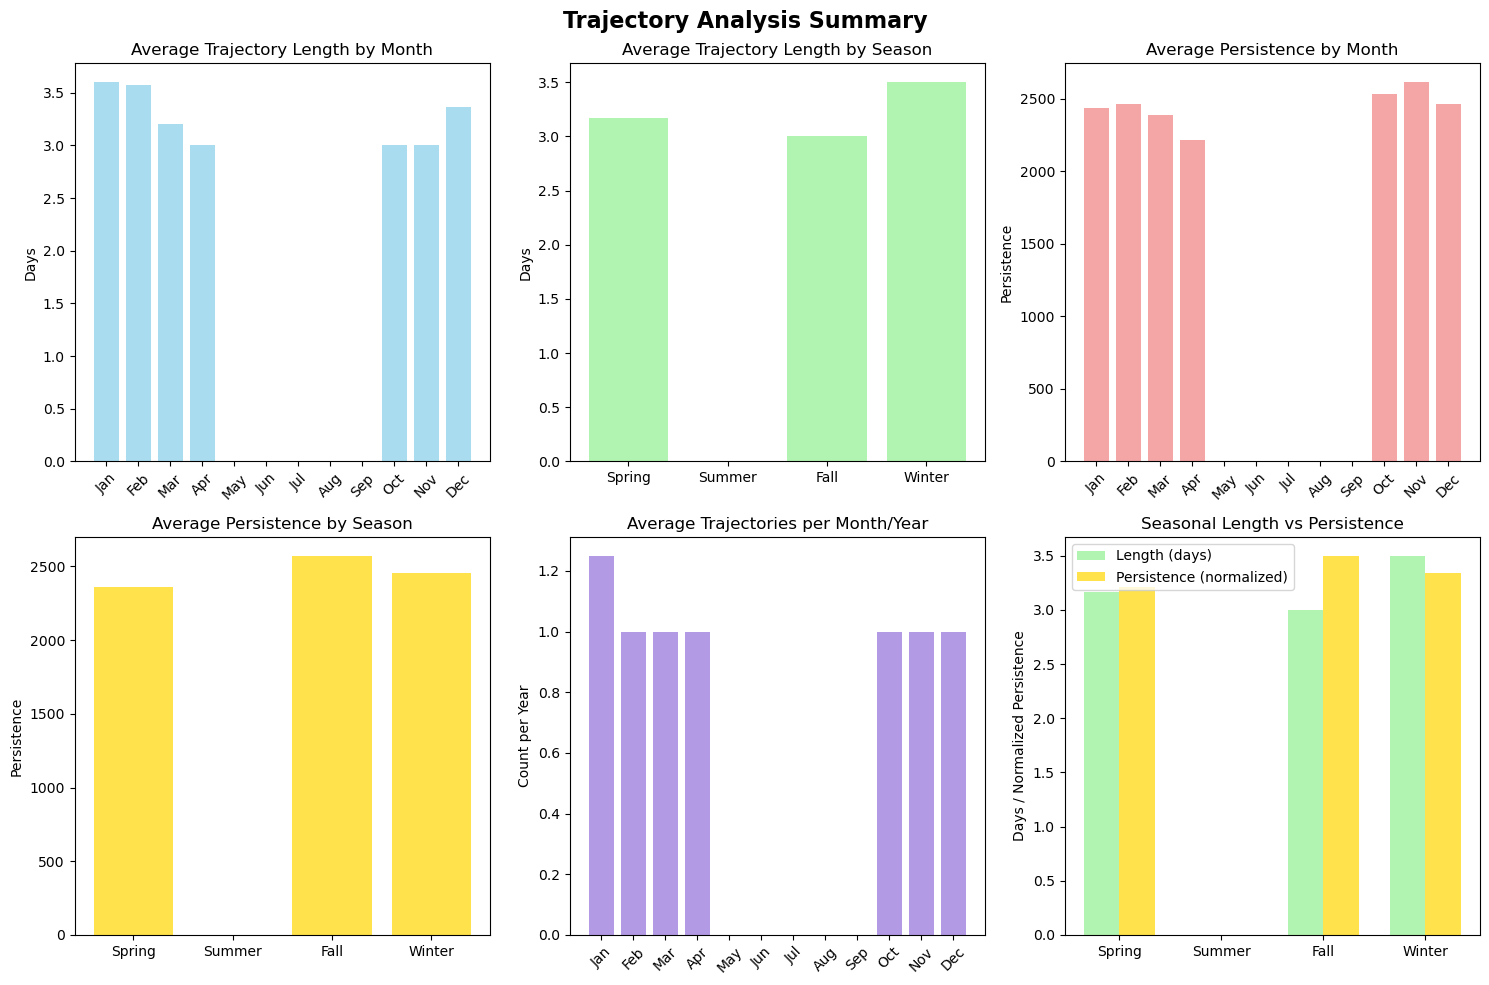

In [37]:
# Usage:
analysis_results = analyze_trajectory_statistics(df_summary,show_figure=True)